# How the White House Affects the Stock Market
### By Jon Khaykin and Richard Doan


In [108]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.signal import wiener
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline  

import re

from bokeh.io import output_notebook, show
from bokeh.charts import Scatter, Line

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from pandas_ml import ConfusionMatrix

regex = re.compile('[^a-zA-Z ]')

def remove_duplicate_dates(df, value_text):
    cur_date = None
    vals = []
    dates = []
    for index, row in df.iterrows():
        if row['Date'] != cur_date:
            vals.append(row[value_text])
            dates.append(row['Date'])
            cur_date = row['Date']
    return pd.Series(vals), dates

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.extend([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

def join_text_on_date(df):
    dates = [None]
    titles = []
    bodies = []
    fmp = []
    fmd = []
    for index, row in df.iterrows():
        if row['Date'] == dates[-1]:
            titles[-1] = titles[-1] + row['Title']
            bodies[-1] = bodies[-1] + row['Body']
        else:
            dates.append(row['Date'])
            fmp.append(row['Filtered Mean Proportion'])
            fmd.append(row['Filtered Mean Delta'])
            titles.append(row['Title'])
            bodies.append(row['Body'])
    return pd.DataFrame({'Date': dates[1:], 'Title': titles, 'Body': bodies, 
                         'Filtered Mean Proportion': fmp, 'Filtered Mean Delta': fmd})

def train_test_split(df):
    all_indices = np.arange(len(df))
    train_indices = np.random.choice(all_indices, 9 * len(all_indices) // 10)
    test_indices = np.setdiff1d(all_indices, train_indices)
    test_df = df.iloc[test_indices]
    df.iloc[test_indices].to_csv('data/dataset-test.csv', index=False)
    df.iloc[train_indices].to_csv('data/dataset-train.csv', index=False)

In [93]:
output_notebook()

Loading BokehJS ...

# Problem Statement

We want to find out if there is a correlation between White House announcements and movements in the stock market. Other works that inspired this include the twitter bot that traded based off of Donald Trump's tweets. Perhaps there is a stronger correlation between White House announcements and what happens in the stock market. This approach will look at the White House as a primary medium of communication between the executive branch of government and traders of the stock market.  **Jon can you do this?**

In [94]:
df = pd.read_csv('data/dataset-train.csv').dropna()
df['Title'] = df['Title'].apply(lambda s: s + ' ')
df['Body'] = df['Body'].apply(lambda post: regex.sub('', post).lower())
df['Body'] = df['Body'].apply(lambda s: s + ' ')
df = df.sort_values(by='Date', ascending=False)

## Calculations
### Definitions
- $ND \triangleq $ NASDAQ
- $SP  \triangleq $ S&P 500
- $DJ  \triangleq $ Dow Jones
- $r_s(t) \triangleq $ closing price of stock $s$ at time $t$.

$Delta_s$ = $r_s(t+1) - r_s(t)$
- Mean Delta = $\frac{1}{3}\sum\limits_{s \in (ND, SP, DJ)} Delta_s$ 

$Proportion_s$ = $\frac{r_s(t+1) - r_s(t)}{r_s(t)}$ 
- Mean Proportion = $\frac{1}{3}\sum\limits_{s \in (ND, SP, DJ)} Proportion_s$ 



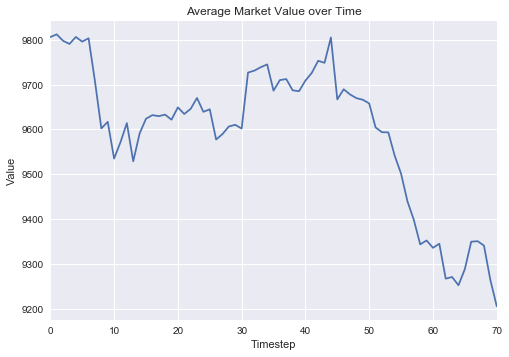

In [95]:
nasdaq_values = df[['Date','Nasdaq Value']]
sp_values = df[['Date','S&P 500 Value']]
dowjones_values = df[['Date','Dow Jones Value']]
nasdaq_values, dates = remove_duplicate_dates(nasdaq_values, 'Nasdaq Value')
sp_values, dates = remove_duplicate_dates(sp_values, 'S&P 500 Value')
dowjones_values, dates = remove_duplicate_dates(dowjones_values, 'Dow Jones Value')
mean_values = (nasdaq_values + dowjones_values + sp_values)/3
# sb.tsplot(nasdaq_values)
# sb.tsplot(dowjones_values)
# sb.tsplot(sp_values)
sb.tsplot(mean_values)
plt.title('Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

## Filtering Stock Market Data

Because we want to predict correlations between the stock market trend and White House blog posts, we decided to get rid of the inherent noise in our stock market data. This way, we eliminate the possibilty of fitting to the noise. The filter we decided to use was the Wiener filter with a sound-to-noise ratio derived from the variance of the stock market data.


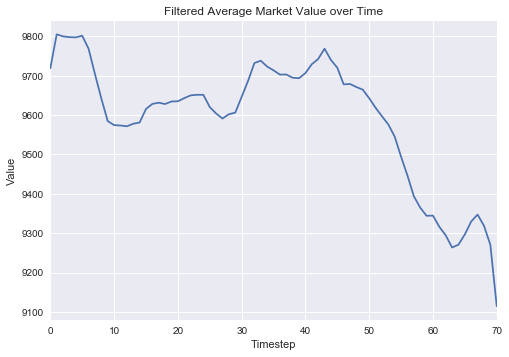

In [96]:
# Filter Values and Reassign
# Filter after averaging
filtered_mean_values = wiener(mean_values, noise=None)
mean_values_df = pd.DataFrame({'Filtered Mean Value': filtered_mean_values, 'Mean Value': mean_values,
                               'Date': dates})
mean_values_df['Filtered Mean Delta'] = -mean_values_df['Filtered Mean Value'].diff(periods=1)
mean_values_df['Mean Delta'] = -mean_values_df['Mean Value'].diff(periods=1)

nasdaq_delta = nasdaq_values.diff(periods=1)
sp_delta = sp_values.diff(periods=1)
dowjones_delta = dowjones_values.diff(periods=1)
mean_values_df['Filtered Mean Proportion'] =  (nasdaq_delta/nasdaq_values + sp_delta/sp_values 
                                               + dowjones_delta/dowjones_values)/3
mean_values_df['Mean Proportion'] = mean_values_df['Mean Delta'] / mean_values_df['Mean Value']

df = pd.merge(df, mean_values_df, on='Date', how='left').dropna()
sb.tsplot(filtered_mean_values)
plt.title('Filtered Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

## Processing the Input Data

Our data will consist of White House blog posts, which is unstructured text data. For our initial analysis, we want to see what topics are present, and if the topics are distinct enough, which topics are most correlated with stock market motions.

In [97]:
# Vectorize Blog Posts with BOW 
initial_vectorizer = CountVectorizer(stop_words='english', min_df=0.05, max_df=0.8)
data = initial_vectorizer.fit_transform(df['Body'])

In [98]:
distances = cosine_distances(data)
mds = MDS(n_components=2, dissimilarity='precomputed')
pos = mds.fit_transform(distances)

In [99]:
lda = LatentDirichletAllocation(n_topics=4, random_state=42, learning_method='online')
topic_scores = lda.fit_transform(data)
labels = np.argmax(topic_scores, axis=1)
df['Topic Label'] = labels


Topic 0:
order secretary united executive states federal law shall state security national agency department agencies director house policy office regulatory section

Topic 1:
think spicer going just thats people dont said im know theres mr administration question hes house sure make clear want

Topic 2:
trump united states american people america vice today minister donald security prime gorsuch americans economic country day national world women

Topic 3:
going thank great people american want applause know thats just right im country really good like jobs think mr say



In [100]:
lda_df = {'x':pos[:, 0], 'y':pos[:,1], 'label':labels}
show(Scatter(lda_df, x='x', y='y', color='label', title='LDA Clusters - Trump'))

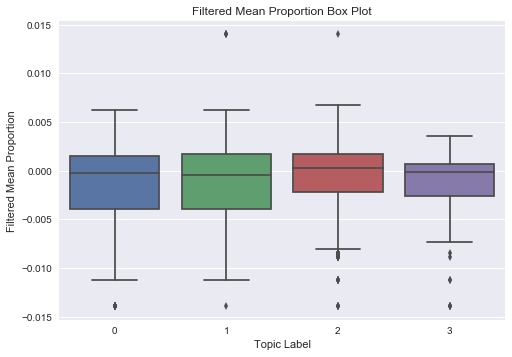

In [101]:
sb.boxplot(x="Topic Label", y="Filtered Mean Proportion", data=df)
plt.title('Filtered Mean Proportion Box Plot')
plt.show()

In [102]:
# Can Skip during presentation
m = df['Filtered Mean Proportion'].mean()
s = df['Filtered Mean Proportion'].std()
print('The total mean is %2.6f' % m)
print('The total std is %2.6f' % s)
print('The 1 std range is (%2.6f, %2.6f)' % (m-s, m+s))
print()
print(df.groupby('Topic Label')['Filtered Mean Proportion'].count())
print()
print(df.groupby('Topic Label')['Filtered Mean Proportion'].mean())
print()
print(df.groupby('Topic Label')['Filtered Mean Proportion'].std())

The total mean is -0.001309
The total std is 0.004534
The 1 std range is (-0.005843, 0.003224)

Topic Label
0    201
1    109
2    300
3    102
Name: Filtered Mean Proportion, dtype: int64

Topic Label
0   -0.001915
1   -0.001299
2   -0.000849
3   -0.001479
Name: Filtered Mean Proportion, dtype: float64

Topic Label
0    0.004690
1    0.005176
2    0.004294
3    0.004065
Name: Filtered Mean Proportion, dtype: float64


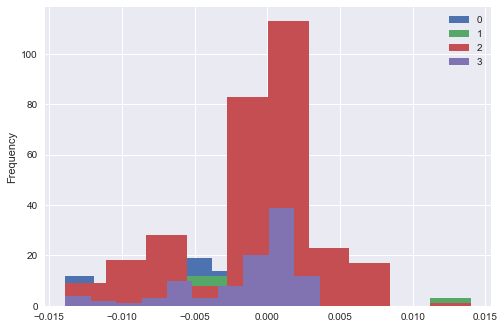

In [103]:
df.groupby('Topic Label')['Filtered Mean Proportion'].plot(kind='hist', legend=True)
plt.show()

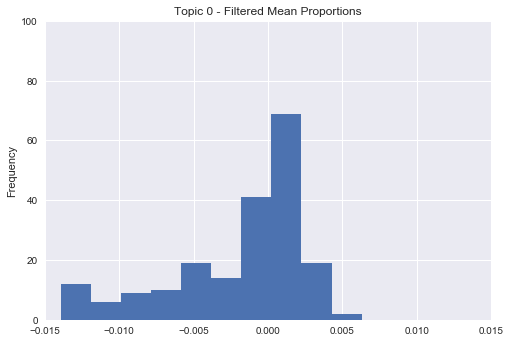

In [104]:
df[df['Topic Label'] == 0]['Filtered Mean Proportion'].plot(kind='hist', xlim=(-0.015, 0.015), ylim=(0,100))
plt.title('Topic 0 - Filtered Mean Proportions')
plt.show()

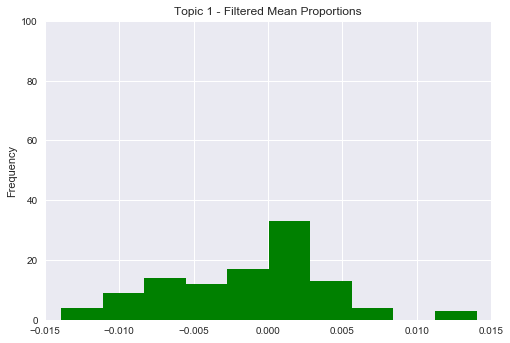

In [105]:
df[df['Topic Label'] == 1]['Filtered Mean Proportion'].plot(kind='hist', xlim=(-0.015, 0.015), color='green', ylim=(0,100))
plt.title('Topic 1 - Filtered Mean Proportions')
plt.show()

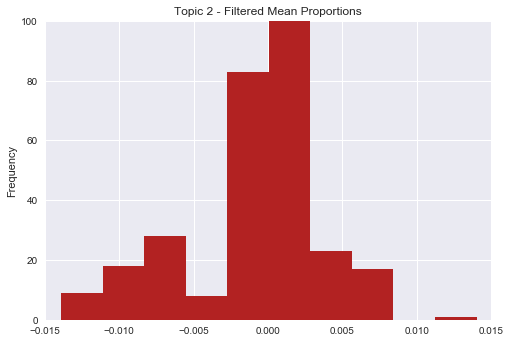

In [106]:
df[df['Topic Label'] == 2]['Filtered Mean Proportion'].plot(kind='hist', xlim=(-0.015, 0.015), color='firebrick', ylim=(0,100))
plt.title('Topic 2 - Filtered Mean Proportions')
plt.show()

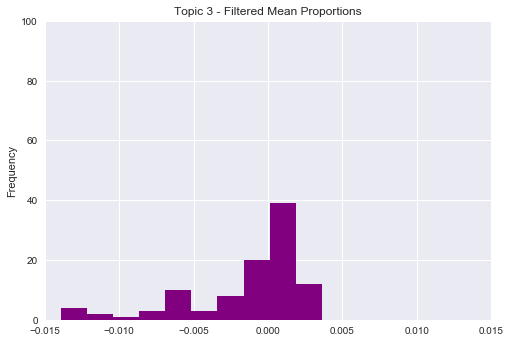

In [107]:
df[df['Topic Label'] == 3]['Filtered Mean Proportion'].plot(kind='hist', xlim=(-0.015, 0.015), color='purple', ylim=(0,100))
plt.title('Topic 3 - Filtered Mean Proportions')
plt.show()

In [109]:
print_top_words(lda, initial_vectorizer.get_feature_names(), 20)


Topic 0:
order secretary united executive states federal law shall state security national agency department agencies director house policy office regulatory section

Topic 1:
think spicer going just thats people dont said im know theres mr administration question hes house sure make clear want

Topic 2:
trump united states american people america vice today minister donald security prime gorsuch americans economic country day national world women

Topic 3:
going thank great people american want applause know thats just right im country really good like jobs think mr say



We notice from above that the topics found by LDA don't seem to differ much in terms of average market motion and spread. From this initial exploration, we can conclude that filtering the input based on topic is not necessary. Now we will concatenate blog posts published the same day to generate our dataset.

# Generating Feature Spaces

For us to be able to train a machine learning model on our text data, we must first structure our data into vector form. From the above topic labeling, we noticed that we could use the highest rated words from our LDA model to generate a dictionary. The idea here is to leverage the information the LDA model learned to reduce the noise in our feature space. Other methods we have tried include `difference of proportions` and `chi-squared rejection`. 

In [111]:
# Revectorize Blog Posts to Label each post with a topic
topic_vectorizer = CountVectorizer(vocabulary=set(get_top_words(lda, initial_vectorizer.get_feature_names(), 50)))
data = topic_vectorizer.transform(df['Body'])
distance = cosine_distances(data)
pos = mds.fit_transform(distance)

In [112]:
topic_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':df['Topic Label']})
show(Scatter(topic_df, x='x', y='y', color='label', title='Topic Feature Space Clusters - Trump'))

In [158]:
# Join the blog posts that are on the same day
joined_data_df = join_text_on_date(df)[['Date', 'Title', 'Body', 'Filtered Mean Delta', 'Filtered Mean Proportion']]
joined_data_df['Label'] = joined_data_df['Filtered Mean Proportion'].apply(lambda x: 1 if x >= 0 else 0)

In [159]:
# Vectorize them using BOW
# Can possibly try a word embeddings model to featurize our blogs
#vectorizer = CountVectorizer(stop_words='english', max_df=0.8, min_df=0.05)
X, y = topic_vectorizer.fit_transform(joined_data_df['Body']), joined_data_df['Label']
X_train, X_test, y_train, y_test = tts(X, y)

In [160]:
# Train Data Plot
distance = cosine_distances(X)
pos = mds.fit_transform(distance)
vis_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':y})
show(Scatter(vis_df, x='x', y='y', color='label', title='Labeled Feature Space'))

             precision    recall  f1-score   support

          0       0.54      0.70      0.61        10
          1       0.25      0.14      0.18         7

avg / total       0.42      0.47      0.43        17



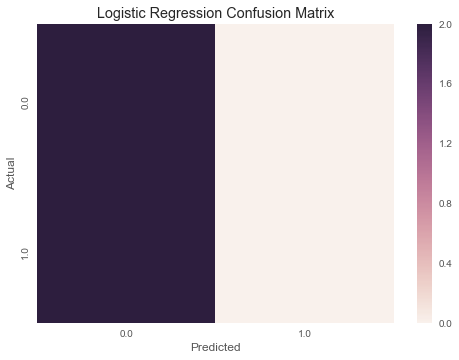

In [147]:
# Linear Model Attempt
log_reg = LogisticRegressionCV(Cs=20)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

             precision    recall  f1-score   support

          0       0.43      0.30      0.35        10
          1       0.30      0.43      0.35         7

avg / total       0.38      0.35      0.35        17



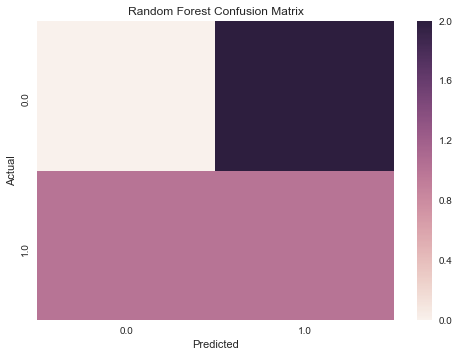

In [144]:
# Random Forest Attempt
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Conclusions

From what we've gathered, we cannot find a correlation between the stock market and White House blog posts. Our lack of finding could be due to many reasons. For example, our design choices when determining the feature space could inhibit our ability to finding clusters. Another pitfall is our lack of data.


In [ ]:
# Submit the data and notebook to Professor Nelson

# Further Investigation into Tweet Trader

In [77]:
from datetime import datetime
from re import sub
tweets_data = pd.read_csv('data/trump_tweets.csv')

tweets_data['Date'] = tweets_data['Date'].apply(lambda s: datetime.strptime(s.split()[0], '%Y-%m-%d'))
tweets_data = tweets_data[tweets_data['Date'] > datetime.strptime('2016-12-25', '%Y-%m-%d')]
tweets_data['Date'] = tweets_data['Date'].apply(lambda s: datetime.strftime(s, '%Y-%m-%d'))
tweets_data = pd.merge(tweets_data, mean_values_df, on='Date', how='inner').dropna()

tweets_data['Text'] = tweets_data['Text'].str.replace('[^a-zA-Z ]', ' ').str.lower()tweets_data

In [78]:
tweets_vectorizer = CountVectorizer(stop_words='english', min_df=0.01, max_df=0.8)
tweets_dtm = tweets_vectorizer.fit_transform(tweets_data['Text'])

In [79]:
distances = cosine_distances(tweets_dtm)
mds = MDS(n_components=2, dissimilarity='precomputed')
pos = mds.fit_transform(distances)

In [83]:
lda = LatentDirichletAllocation(n_topics=7, random_state=42, learning_method='online')
topic_scores = lda.fit_transform(tweets_dtm)
labels = np.argmax(topic_scores, axis=1)
tweets_data['Topic Label'] = labels

print_top_words(lda, tweets_vectorizer.get_feature_names(), 20)

lda_df = {'x':pos[:, 0], 'y':pos[:,1], 'label':labels}
show(Scatter(lda_df, x='x', y='y', color='label', title='LDA Clusters - Trump'))


Topic 0:
democrats long time iran deal minister prime terrible cabinet obama going america winning security billion safety insurance general make mexico

Topic 1:
jobs healthcare great american obamacare going state help today republicans meeting congress north korea years new companies china com higher

Topic 2:
com twitter pic http great wh gov today whitehouse thank honor https welcome support join america vp meeting watch american

Topic 3:
news fake media trump russia story just election country http nytimes failing people cnn democrats com real great big abc

Topic 4:
big court supreme people bad ban illegal forward week states immigration looking country great day united job rally tomorrow look

Topic 5:
enjoy tonight interviewed interview years failing new wrong decision just did nytimes illegal big deal abc total foxandfriends clinton way

Topic 6:
president trump www com business https ceo office women united states press great day getting whitehouse gov meeting forward html

It seems like everything but topic 2 seems interesting...

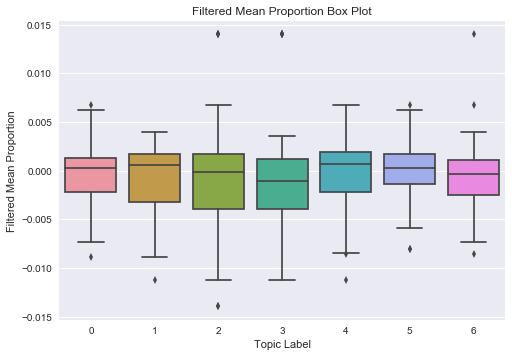

In [84]:
sb.boxplot(x="Topic Label", y="Filtered Mean Proportion", data=tweets_data)
plt.title('Filtered Mean Proportion Box Plot')
plt.show()

In [85]:
dates = [None]
text = []
fmp = []
fmd = []
for index, row in tweets_data.iterrows():
    if row['Topic Label'] == 2:
        continue
    if row['Date'] == dates[-1]:
        text[-1] = text[-1] + ' ' + row['Text']
    else:
        dates.append(row['Date'])
        fmp.append(row['Filtered Mean Proportion'])
        fmd.append(row['Filtered Mean Delta'])
        text.append(row['Text'])
        
tweets_df = pd.DataFrame({'Date': dates[1:], 'Text': text, 
                         'Filtered Mean Proportion': fmp, 'Filtered Mean Delta': fmd})[['Date', 'Text',
                                                                                        'Filtered Mean Proportion','Filtered Mean Delta']]
tweets_df['Label'] = tweets_df['Filtered Mean Proportion'].apply(lambda x: 1 if x >= 0 else 0)
tweets_df

,Date,Text,Filtered Mean Proportion,Filtered Mean Delta,Label
0,2017-05-02,trump russia story was an excuse used by th...,0.001544,-86.105704,1
1,2017-05-01,president andrew jackson who died years be...,-0.001183,5.140055,0
2,2017-04-28,loudobbs just stated that president trump s...,-0.002572,1.932292,0
3,2017-04-27,as families prepare for summer vacations in ou...,0.001360,0.624593,1
4,2017-04-26,democrats are trying to bail out insurance com...,-0.001595,-4.211100,0
5,2017-04-25,don t let the fake media tell you that i have ...,0.000510,33.019965,1
6,2017-04-24,if our healthcare plan is approved you will s...,-0.008080,64.533339,0
7,2017-04-21,china is very much the economic lifeline to no...,-0.011253,62.098741,0
8,2017-04-20,failing nytimes which has been calling me wr...,0.001866,57.352268,1
9,2017-04-19,dems failed in kansas and are now failing in g...,-0.008421,10.225586,0


In [86]:
X, y = tweets_vectorizer.fit_transform(tweets_df['Text']), tweets_df['Label']
X_train, X_test, y_train, y_test = tts(X, y)

In [87]:
distance = cosine_distances(X)
pos = mds.fit_transform(distance)
vis_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':y})
show(Scatter(vis_df, x='x', y='y', color='label', title='Labeled Feature Space'))

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.31      1.00      0.48         5
          1       0.00      0.00      0.00        11

avg / total       0.10      0.31      0.15        16



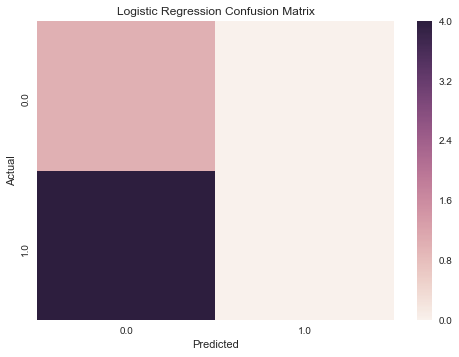

In [88]:
# Linear Model Attempt
log_reg = LogisticRegressionCV(Cs=20)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

             precision    recall  f1-score   support

          0       0.33      1.00      0.50         5
          1       1.00      0.09      0.17        11

avg / total       0.79      0.38      0.27        16



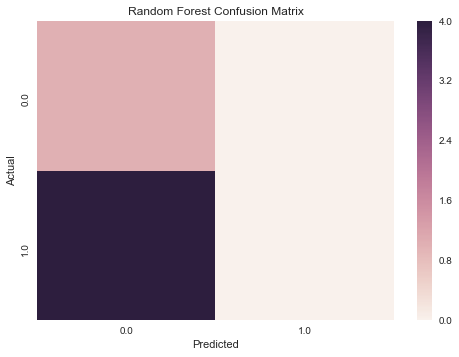

In [89]:
# Random Forest Attempt
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Twitter Bot Conclusion

Trump may have very pointed influence on with low frequency on the stock market as opposed to long term content based correlation.